### Multi-Input Models

#### Why Multi-input?
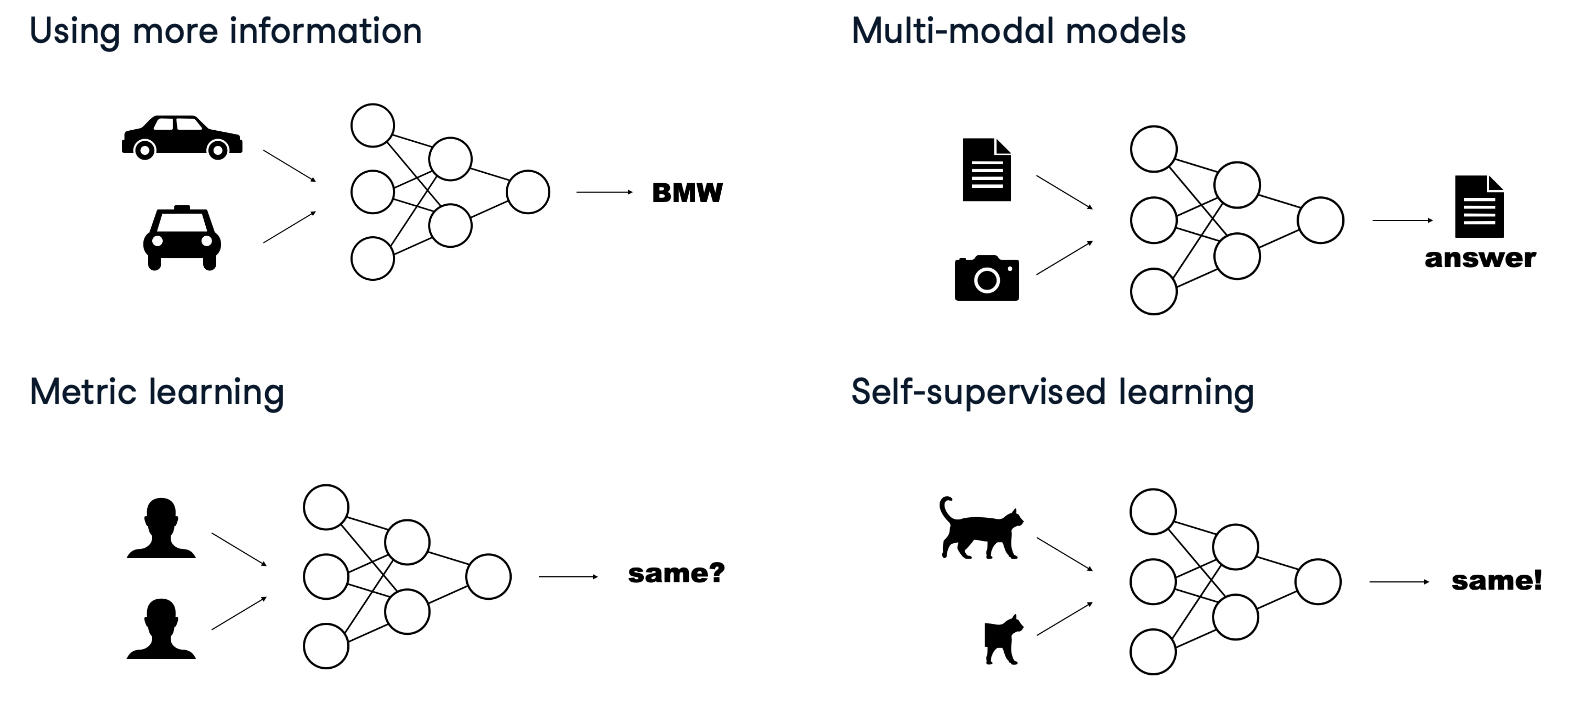

#### Omniglot Dataset
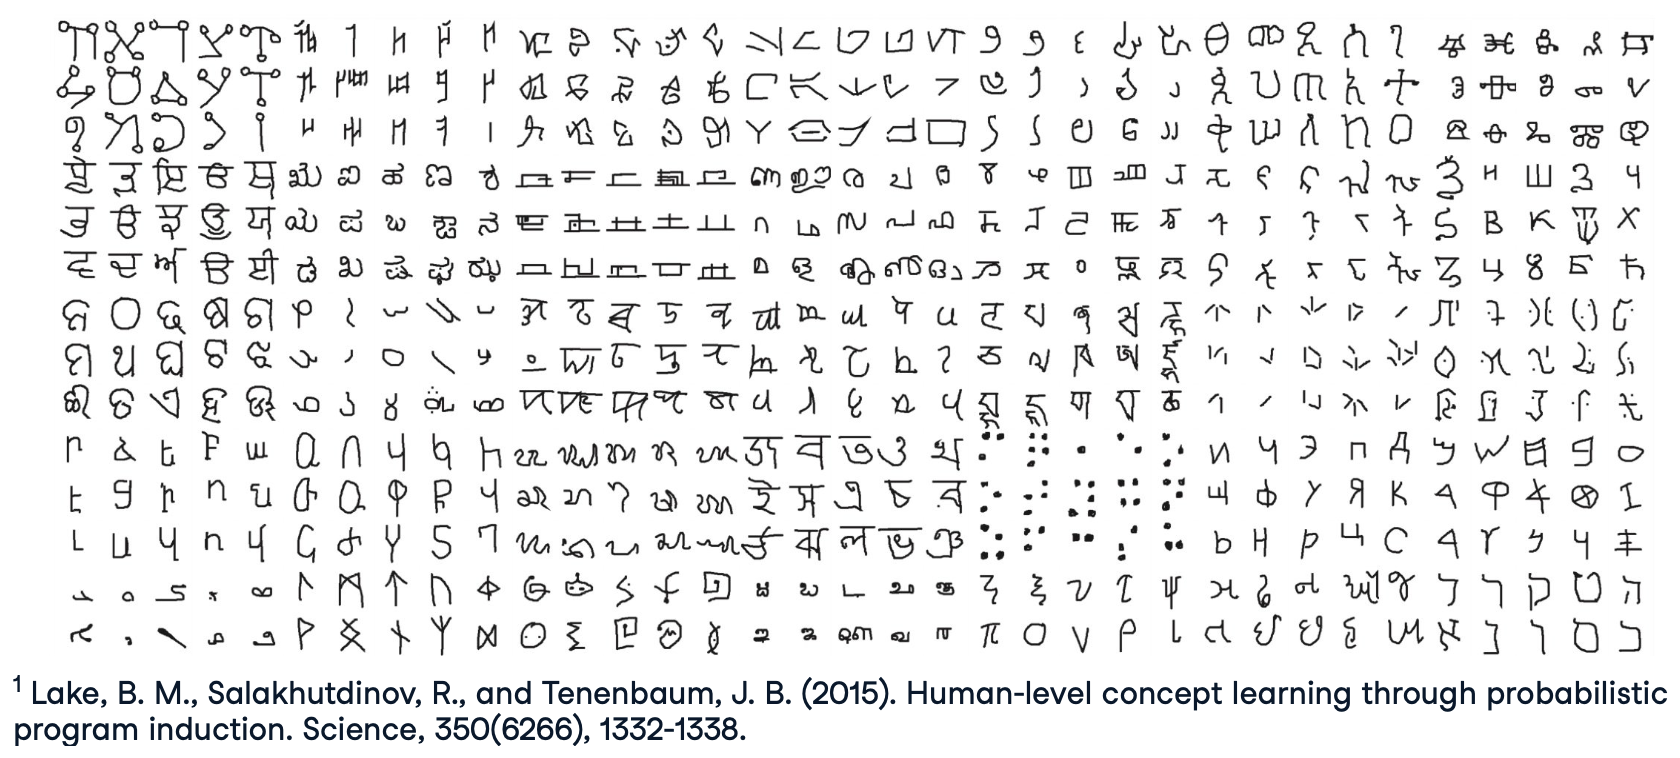

#### Character Classification
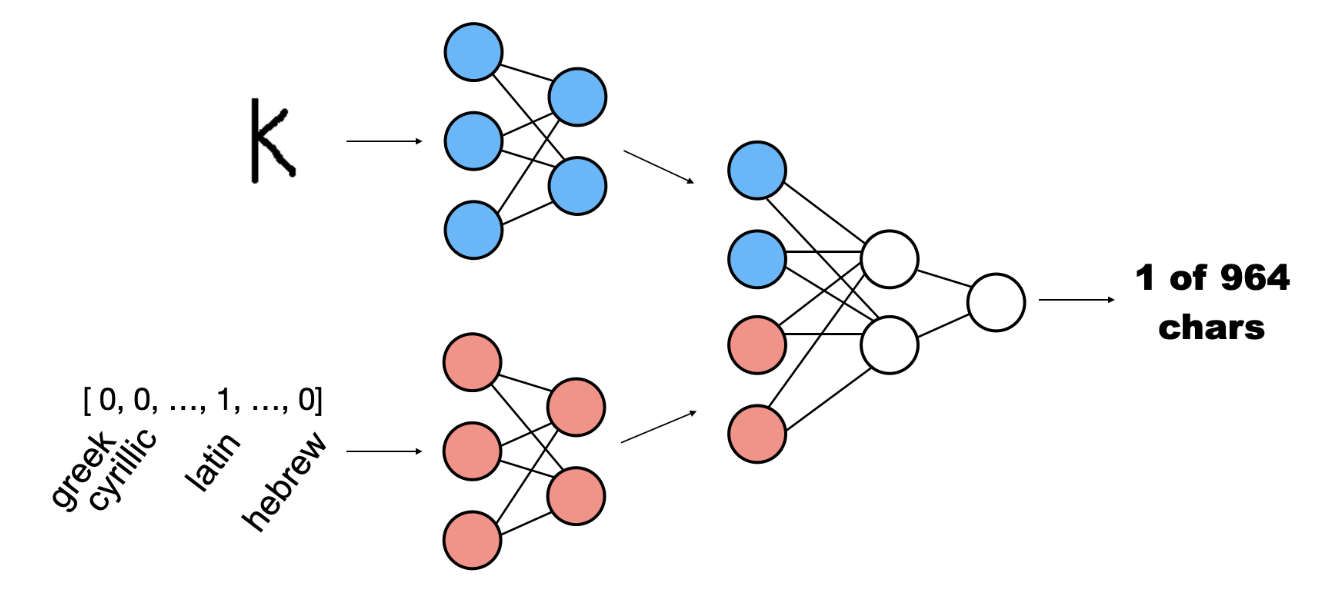

#### Two-input Dataset

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from collections import defaultdict

# Dataset class
class OmniglotDataset(Dataset):
    def __init__(self, transform, samples):       
        self.transform = transform        
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):       
        img_path, alphabet, label = self.samples[idx]        
        img = Image.open(img_path).convert('L')       
        img = self.transform(img)
        
        return img, alphabet, label

In [2]:
# Assign samples and transforms
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor()
# ])

# # Load the samples from the dataset folder
# samples = load_omniglot_samples('omniglot_train')

# # Check the first sample
# print(samples[0]) 

- Implement __len__()
- Load and transform image
- Return both inputs and label

#### Tensor Concatenation 

In [3]:
x = torch.tensor([  
    [1, 2, 3],
])

y = torch.tensor([  
    [4, 5, 6],
])

In [4]:
# Concatenation along axis 0

torch.cat((x, y), dim=0)

tensor([[1, 2, 3],
        [4, 5, 6]])

In [5]:
# Concatenation along axis 1

torch.cat((x, y), dim=1)

tensor([[1, 2, 3, 4, 5, 6]])

#### Two-input Architecture

In [6]:
# Neural Network
class Net(nn.Module):
    def __init__(self, num_alphabets=30, num_classes=964):
        super().__init__()       
        self.image_layer = nn.Sequential(           
            nn.Conv2d(1, 16, kernel_size=3, padding=1),          
            nn.MaxPool2d(kernel_size=2),          
            nn.ELU(),           
            nn.Flatten(),         
            nn.Linear(16*32*32, 128)       
        )        
        self.alphabet_layer = nn.Sequential(           
            nn.Linear(num_alphabets, 8),         
            nn.ELU(),     
        )       
        self.classifier = nn.Sequential(          
            nn.Linear(128 + 8, num_classes),       
        )
    
    def forward(self, x_image, x_alphabet):   
        x_image = self.image_layer(x_image)
        x_alphabet = self.alphabet_layer(x_alphabet)  
        x = torch.cat((x_image, x_alphabet), dim=1)
        return self.classifier(x)

- Define image processing layer
- Define alphabet processing layer
- Define classifier layer

In [7]:
# def forward(self, x_image, x_alphabet):    
#     x_image = self.image_layer(x_image)    
#     x_alphabet = self.alphabet_layer(x_alphabet)    
#     x = torch.cat((x_image, x_alphabet), dim=1)
    
#     return self.classifier(x)

- Pass image through image layer
- Pass alphabet through alphabet layer
- Concatenate image and alphabet outputs
- Pass the result through classifier<br><br>

#### Training Loop

In [8]:
# Data preparation function
def prepare_omniglot_data(data_dir='omniglot_train'):
    """
    Prepare Omniglot dataset samples and create mappings
    """
    samples = []
    alphabet_to_idx = {}
    char_to_idx = {}
    
    alphabet_idx = 0
    char_idx = 0
    
    # Walk through the dataset directory
    for alphabet in os.listdir(data_dir):
        alphabet_path = os.path.join(data_dir, alphabet)
        if not os.path.isdir(alphabet_path):
            continue
            
        if alphabet not in alphabet_to_idx:
            alphabet_to_idx[alphabet] = alphabet_idx
            alphabet_idx += 1
        
        for character in os.listdir(alphabet_path):
            char_path = os.path.join(alphabet_path, character)
            if not os.path.isdir(char_path):
                continue
                
            char_key = f"{alphabet}_{character}"
            if char_key not in char_to_idx:
                char_to_idx[char_key] = char_idx
                char_idx += 1
            
            # Add all images for this character
            for img_file in os.listdir(char_path):
                if img_file.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(char_path, img_file)
                    samples.append((img_path, alphabet_to_idx[alphabet], char_to_idx[char_key]))
    
    return samples, alphabet_to_idx, char_to_idx

In [9]:
# Custom collate function to handle alphabet encoding
def custom_collate_fn(batch, num_alphabets):
    images, alphabets, labels = zip(*batch)
    
    # Stack images and labels
    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.long)
    
    # One-hot encode alphabets
    alphabet_tensor = torch.zeros(len(alphabets), num_alphabets)
    for i, alphabet_idx in enumerate(alphabets):
        alphabet_tensor[i, alphabet_idx] = 1.0
    
    return images, alphabet_tensor, labels

In [10]:
# Main training code
def main():
    # Prepare data
    print("Preparing Omniglot data...")
    samples, alphabet_to_idx, char_to_idx = prepare_omniglot_data('omniglot_train')
    
    num_alphabets = len(alphabet_to_idx)
    num_classes = len(char_to_idx)
    
    print(f"Found {len(samples)} samples across {num_alphabets} alphabets and {num_classes} characters")
    
    # Create dataset and dataloader
    dataset_train = OmniglotDataset(
        transform=transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ]),
        samples=samples,
    )
    
    # Custom collate function to handle alphabet encoding
    collate_fn = lambda batch: custom_collate_fn(batch, num_alphabets)
    
    dataloader_train = DataLoader(
        dataset_train, 
        shuffle=True, 
        batch_size=32,  # Increased batch size for better training
        collate_fn=collate_fn
    )
    
    # Initialize model, loss, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = Net(num_alphabets=num_alphabets, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)  # Adam often works better than SGD
    
    # Training loop
    print("Starting training...")
    for epoch in range(10):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (img, alpha, labels) in enumerate(dataloader_train):        
            img, alpha, labels = img.to(device), alpha.to(device), labels.to(device)
            
            optimizer.zero_grad()      
            outputs = net(img, alpha)       
            loss = criterion(outputs, labels)       
            loss.backward()      
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 100 == 99:  # Print every 100 batches
                print(f'Epoch [{epoch+1}/10], Batch [{batch_idx+1}], '
                      f'Loss: {running_loss/100:.4f}, '
                      f'Accuracy: {100*correct/total:.2f}%')
                running_loss = 0.0
        
        # Epoch summary
        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/10] completed. Accuracy: {epoch_acc:.2f}%')
    
    print("Training completed!")
    
    # Save the model
    torch.save({
        'model_state_dict': net.state_dict(),
        'alphabet_to_idx': alphabet_to_idx,
        'char_to_idx': char_to_idx,
        'num_alphabets': num_alphabets,
        'num_classes': num_classes
    }, 'omniglot_model.pth')
    
    print("Model saved as 'omniglot_model.pth'")

if __name__ == "__main__":
    main()

Preparing Omniglot data...
Found 13251 samples across 29 alphabets and 915 characters
Starting training...
Epoch [1/10], Batch [100], Loss: 7.1883, Accuracy: 0.25%
Epoch [1/10], Batch [200], Loss: 6.5059, Accuracy: 0.92%
Epoch [1/10], Batch [300], Loss: 5.8273, Accuracy: 1.99%
Epoch [1/10], Batch [400], Loss: 5.0681, Accuracy: 4.02%
Epoch [1/10] completed. Accuracy: 4.31%
Epoch [2/10], Batch [100], Loss: 3.4803, Accuracy: 30.09%
Epoch [2/10], Batch [200], Loss: 3.1895, Accuracy: 32.16%
Epoch [2/10], Batch [300], Loss: 3.0480, Accuracy: 32.83%
Epoch [2/10], Batch [400], Loss: 2.7845, Accuracy: 34.74%
Epoch [2/10] completed. Accuracy: 34.82%
Epoch [3/10], Batch [100], Loss: 1.6177, Accuracy: 63.41%
Epoch [3/10], Batch [200], Loss: 1.6897, Accuracy: 62.20%
Epoch [3/10], Batch [300], Loss: 1.5992, Accuracy: 62.31%
Epoch [3/10], Batch [400], Loss: 1.6962, Accuracy: 61.95%
Epoch [3/10] completed. Accuracy: 62.05%
Epoch [4/10], Batch [100], Loss: 0.7862, Accuracy: 83.09%
Epoch [4/10], Batch [

Training data consists of three items:
- Image
- Alphabet vector
- Labels

We pass the model images and alphabets

### Multi-Output Models

#### Why Multi-output?
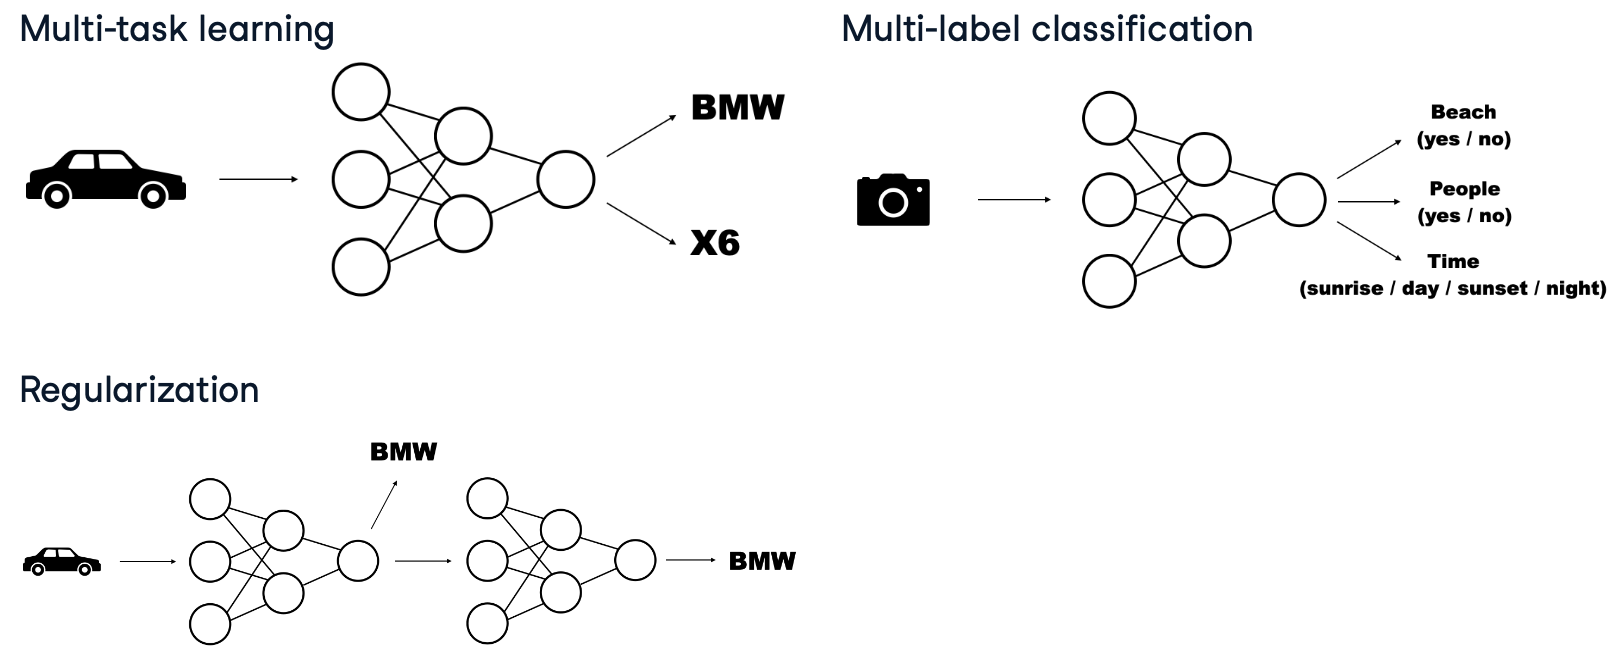

#### Character and alphabet classification
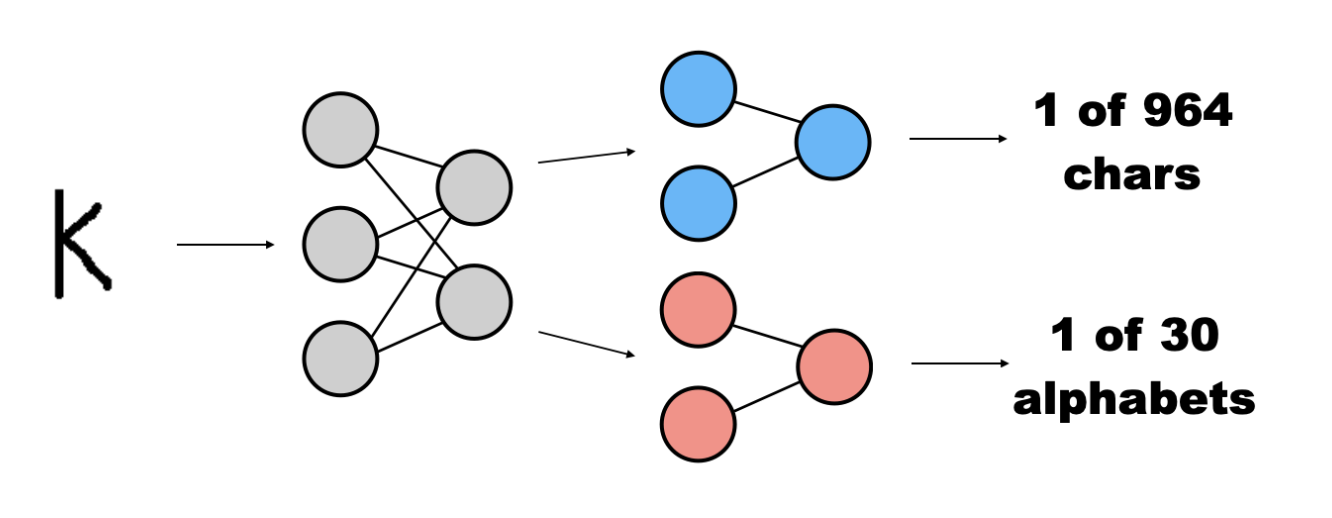

#### Two-output Dataset

In [ ]:
class OmniglotDataset(Dataset):
    def __init__(self, transform, samples, alphabet_to_idx, char_to_idx):      
        self.transform = transform       
        self.samples = samples
        self.alphabet_to_idx = alphabet_to_idx
        self.char_to_idx = char_to_idx
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):        
        img_path, alphabet_name, char_name = self.samples[idx]
        
        # Load and transform image
        img = Image.open(img_path).convert('L')       
        img = self.transform(img)
        
        # Convert names to indices
        alphabet_idx = self.alphabet_to_idx[alphabet_name]
        char_key = f"{alphabet_name}_{char_name}"
        char_idx = self.char_to_idx[char_key]
        
        return img, alphabet_idx, char_idx

#### Two-output Architecture

In [ ]:
class Net(nn.Module):
    def __init__(self, num_alpha, num_char):
        super().__init__()        
        self.image_layer = nn.Sequential(           
            nn.Conv2d(1, 16, kernel_size=3, padding=1),           
            nn.MaxPool2d(kernel_size=2),            
            nn.ELU(),            
            nn.Flatten(),            
            nn.Linear(16*32*32, 128)       
        )      
        self.classifier_alpha = nn.Linear(128, 30)  
        self.classifier_char = nn.Linear(128, 964)
    
    def forward(self, x):       
        x_image = self.image_layer(x)        
        output_alpha = self.classifier_alpha(x_image)       
        output_char = self.classifier_char(x_image)
        return output_alpha, output_char

- Define image-processing sub-network
- Define output-specific classifiers
- Pass image through dedicated sub-network
- Pass the result through each output layer
- Return both outputs

#### Training Loop

In [ ]:
for epoch in range(10):
    for images, labels_alpha, labels_char \
    in dataloader_train:        
        optimizer.zero_grad()        
        outputs_alpha, outputs_char = net(images)       
        loss_alpha = criterion(         
            outputs_alpha, labels_alpha        
        )       
        loss_char = criterion(         
            outputs_char, labels_char       
        )     
        loss = loss_alpha + loss_char        
        loss.backward()      
        optimizer.step()

### Evaluation of Multi-output Models and Loss Weighting

#### Model Evaluation

In [ ]:
acc_alpha = Accuracy(    
    task="multiclass", num_classes=30)

acc_char = Accuracy(    
    task="multiclass", num_classes=964)

net.eval()

with torch.no_grad():
    for images, labels_alpha, labels_char \
    in dataloader_test:       
        out_alpha, out_char = net(images)      
        _, pred_alpha = torch.max(out_alpha, 1)       
        _, pred_char = torch.max(out_char, 1)       
        acc_alpha(pred_alpha, labels_alpha)        
        acc_char(pred_char, labels_char)

- Set up metric for each output
- Iterate over test loader and get outputs
- Calculate prediction for each output
- Update accuracy metrics
- Calculate final accuracy scores

In [ ]:
print(f"Alphabet: {acc_alpha.compute()}")
print(f"Character: {acc_char.compute()}")

#### Multi-output training loop revisited

In [ ]:
for epoch in range(10):
    for images, labels_alpha, labels_char \
    in dataloader_train:       
        optimizer.zero_grad()       
        outputs_alpha, outputs_char = net(images)       
        loss_alpha = criterion(         
            outputs_alpha, labels_alpha       
        )        loss_char = criterion(          
            outputs_char, labels_char      
        )      
        loss = loss_alpha + loss_char       
        loss.backward()       
        optimizer.step()

- Two losses: for alphabets and characters
- Final loss defined as sum of alphabet and character losses: `loss = loss_alpha + loss_char`
- Both classification tasks deemed equally important<br><br>

#### Varying task importance 
Character classification 2 times more important than alphabet classification
- Approach 1: Scale more important loss by a factor of 2
  - `loss = loss_alpha + loss_char * 2`<br><br>
- Approach 2: Assign weights that sum to 1
  - `loss = 0.33 * loss_alpha + 0.67 * loss_char`<br><br>

#### Warning: losses on different scales 
- Losses must be on the same scale before they are weighted and added
- Example tasks:
  - Predict house price -> MSE loss
  - Predict quality: low, medium, high -> CrossEntropy loss<br><br>
- CrossEntropy is typically in the single-digits
- MSE loss can reach tens of thousands
- Model would ignore quality assessment task
- Solution: Normalize both losses before weighting and adding

In [ ]:
loss_price = loss_price / torch.max(loss_price)
loss_quality = loss_quality / torch.max(loss_quality)
loss = 0.7 * loss_price + 0.3 * loss_quality